In [55]:
import numpy as np 
import pandas as pd 
import re
import nltk 
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import model_selection
from mlxtend.plotting import plot_confusion_matrix
from sklearn import metrics

In [56]:
tweets = pd.read_csv("//content/Tweets.csv")

In [57]:
tweets.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [58]:
tweets.isnull().mean() * 100

tweet_id                         0.000000
airline_sentiment                0.000000
airline_sentiment_confidence     0.000000
negativereason                  41.166718
negativereason_confidence       31.716921
airline                          0.000000
airline_sentiment_gold          99.725417
name                             0.000000
negativereason_gold             99.782406
retweet_count                    0.000000
text                             0.000000
tweet_coord                     93.099161
tweet_created                    0.000000
tweet_location                  32.178013
user_timezone                   32.110662
dtype: float64

#### replace null with 0 in the dataframe

In [59]:
tweets.fillna(0,inplace=True)

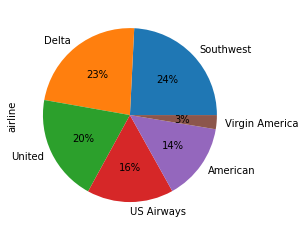

In [60]:
tweets.airline.value_counts().plot(kind='pie', autopct='%1.0f%%')

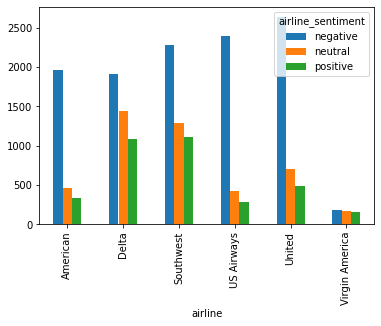

In [61]:
airline_sentiment = tweets.groupby(['airline', 'airline_sentiment']).airline_sentiment.count().unstack()
airline_sentiment.plot(kind='bar')

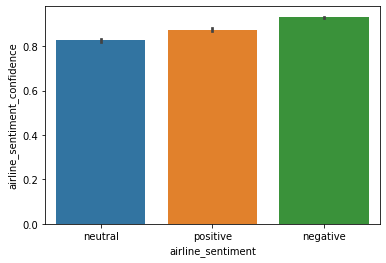

In [62]:
sn.barplot(x='airline_sentiment', y='airline_sentiment_confidence' , data=tweets)

## Data Cleaning

In [63]:
features = tweets.iloc[:, 10].values
labels = tweets.iloc[:, 1].values

In [64]:
tweets['airline_sentiment'].unique()

array(['neutral', 'positive', 'negative'], dtype=object)

In [65]:
tweets['airline_sentiment'] = tweets['airline_sentiment'].map({'neutral':0,'positive':1,'negative':2})
tweets['airline_sentiment']

0        0
1        1
2        0
3        2
4        2
        ..
19297    1
19298    2
19299    0
19300    2
19301    0
Name: airline_sentiment, Length: 19302, dtype: int64

In [66]:
labels

array(['neutral', 'positive', 'neutral', ..., 'neutral', 'negative',
       'neutral'], dtype=object)

### Preprocess the data and remove unnecessary samples

In [67]:
processed_features = []

for sentence in range(0, len(features)):
    # Remove all the special characters
    processed_feature = re.sub(r'\W', ' ', str(features[sentence]))

    # remove all single characters
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)

    # Remove single characters from the start
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature) 

    # Substituting multiple spaces with single space
    processed_feature = re.sub(r'\s+', ' ', processed_feature, flags=re.I)

    # Removing prefixed 'b'
    processed_feature = re.sub(r'^b\s+', '', processed_feature)

    # Converting to Lowercase
    processed_feature = processed_feature.lower()

    processed_features.append(processed_feature)
    
#processed_features

In [79]:
print(features[1:100])

["@VirginAmerica plus you've added commercials to the experience... tacky."
 "@VirginAmerica I didn't today... Must mean I need to take another trip!"
 '@VirginAmerica it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse'
 "@VirginAmerica and it's a really big bad thing about it"
 "@VirginAmerica seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA"
 '@VirginAmerica yes, nearly every time I fly VX this “ear worm” won’t go away :)'
 '@VirginAmerica Really missed a prime opportunity for Men Without Hats parody, there. https://t.co/mWpG7grEZP'
 "@virginamerica Well, I didn't…but NOW I DO! :-D"
 "@VirginAmerica it was amazing, and arrived an hour early. You're too good to me."
 '@VirginAmerica did you know that suicide is the second leading cause of death among teens 10-24'
 '@VirginAmerica I &lt;3 pretty graphics. so much better than minimal iconography. :D'
 "

## Vectorize the sentances

In [69]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(processed_features)
X.toarray()
y = tweets['airline_sentiment']

In [70]:
def kfold_train_test_split(x, y, train_indices, test_indices):
  return x[train_indices], x[test_indices], y[train_indices], y[test_indices]

## Split the data and Building the model

In [139]:
stratified_shuffled_k_fold = model_selection.StratifiedShuffleSplit(n_splits=2)

scores = [] 


for train_indices, test_indices in stratified_shuffled_k_fold.split(X,y):
  # Split data using our predefined function
  x_train, x_test, y_train, y_test = kfold_train_test_split(X, y, train_indices, test_indices)

  # Train model
  randomforest_model = RandomForestClassifier()
  randomforest_model.fit(x_train, y_train)

  # Predict using test set
  y_pred_train = randomforest_model.predict(x_train)
  y_pred = randomforest_model.predict(x_test)

  # Calculate scores
  accuracy = accuracy_score(y_test, y_pred)

  # Create scores dictionary
  scores_dict = {"accuracy": accuracy}

  # Append to scores array
  scores.append(scores_dict)


scores_df = pd.DataFrame(scores)
scores_df

,accuracy
0,0.864319
1,0.877784


In [112]:
len(train_indices)


17371

In [72]:
scores_df['accuracy'].mean()

0.8713102019678922

In [178]:
import random
labs=np.array(['neutral', 'positive', 'negative'])
vectorizer = TfidfVectorizer(stop_words="english")
prediction_train = randomforest_model.predict(x_train)
prediction = randomforest_model.predict(x_test)

for i in range(200):
    print(features[test_indices[i]])
    predictions1=(prediction[i])
    print('Result is :',labs[predictions1])



@USAirways epic fail @ CLT ystrdy w/Cancelled Flightled flights. No staff, no communication &amp; no refund for unused portion of tix. Keep it classy guys
Result is : negative
@SouthwestAir  when you take my money and do not provide a service makes for a profitable venture for your company. #IsItTheGaryKellyWay?
Result is : negative
@JetBlue the fact that #ChrisHasMadeUsBLUSH isn't trending is how you know I'm loyal ;)
Result is : neutral
@JetBlue being told JFK had a 5 hour delay this AM which is reason for my delay now. It can't be that hard to notify with 12 hours notice
Result is : negative
@SouthwestAir your checkin system is #poor
Result is : negative
@AmericanAir thanks, I'll look forward to the response.
Result is : positive
@united the only difference being you are both responsible and in a position to do something about them. Learn from @Delta
Result is : negative
@SouthwestAir I would love to go to the Atlanta show ♥️
Result is : positive
@JetBlue where do I add my AA loyalt

accuracy test score is: 0.8824443293630243
accuracy train score is: 0.9957975936906338

---------------------------------------------------------



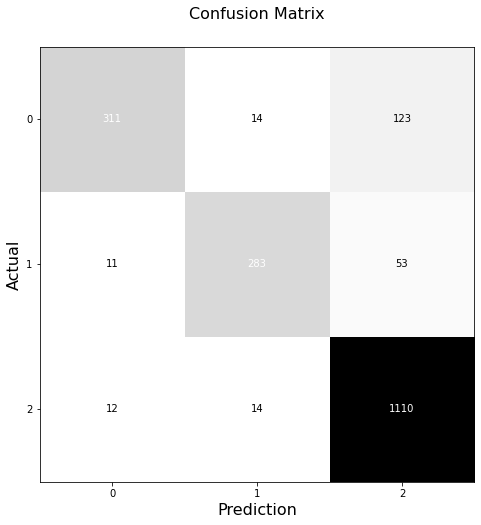


---------------------------------------------------------

              precision    recall  f1-score   support

           0       0.93      0.69      0.80       448
           1       0.91      0.82      0.86       347
           2       0.86      0.98      0.92      1136

    accuracy                           0.88      1931
   macro avg       0.90      0.83      0.86      1931
weighted avg       0.89      0.88      0.88      1931



In [75]:
prediction_train = randomforest_model.predict(x_train)
prediction = randomforest_model.predict(x_test)

print(f'accuracy test score is: {accuracy_score(y_test,prediction)}')
print(f'accuracy train score is: {accuracy_score(y_train,prediction_train)}')

print()
print('---------------------------------------------------------')
print()

confusion_matrix=metrics.confusion_matrix(y_test,prediction)
fig= plot_confusion_matrix(conf_mat=confusion_matrix,cmap=plt.cm.Greys,figsize=(8,8))
plt.xlabel('Prediction',fontsize=16)
plt.ylabel('Actual',fontsize=16)
plt.title('Confusion Matrix',fontsize=16)
plt.show()

print()
print('---------------------------------------------------------')
print()

'''
   precision = TP/TP+FP
   recall = TP/TP+FN
   f1 = 2*precision*recall/precision+recall
   accuracy = TP+TF/Total Samples
'''

accuracy_report = classification_report(y_test,prediction)
print(accuracy_report)